In [ ]:
# Copyright 2021 Google LLC. All Rights Reserved.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

#@title Setup Environment
#@markdown Install MT3 and its dependencies (may take a few minutes).

!apt-get update -qq && apt-get install -qq libfluidsynth1 build-essential libasound2-dev libjack-dev

!pip install --upgrade pip
!pip install --upgrade jaxlib -f https://storage.googleapis.com/jax-releases/jax_releases.html
!pip install nest-asyncio
!pip install pyfluidsynth

# install t5x
!git clone --branch=main https://github.com/google-research/t5x
!mv t5x t5x_tmp; mv t5x_tmp/* .; rm -r t5x_tmp
!sed -i 's:jax\[tpu\]:jax:' setup.py
!python3 -m pip install -e .

# install mt3
!git clone --branch=main https://github.com/magenta/mt3
!mv mt3 mt3_tmp; mv mt3_tmp/* .; rm -r mt3_tmp
!python3 -m pip install -e .

# copy checkpoints
!gsutil -q -m cp -r gs://mt3/checkpoints .

# copy soundfont (originally from https://sites.google.com/site/soundfonts4u)
!gsutil -q -m cp gs://magentadata/soundfonts/SGM-v2.01-Sal-Guit-Bass-V1.3.sf2 .



Selecting previously unselected package libfluidsynth1:amd64.
(Reading database ... 155229 files and directories currently installed.)
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 1.7 MB 31.4 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html
     |████████████████████████████████| 153.1 MB 56 kB/s             
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.1.71+cuda111
    Uninstalling jaxlib-0.1.71+cuda111:
      Successfully uninstalled jaxlib-0.1.71+cuda111


Cloning into 't5x'...
remote: Enumerating objects: 1093, done.
remote: Counting objects: 100% (476/476), done.
remote: Compressing objects: 100% (205/205), done.
remote: Total 1093 (delta 336), reused 336 (delta 271), pack-reused 617
Receiving objects: 100% (1093/1093), 6.31 MiB | 22.26 MiB/s, done.
Resolving deltas: 100% (720/720), done.
Obtaining file:///content
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/google/CommonLoopUtils to /tmp/pip-install-4gu6kmes/clu_ad69359d8cee4830857a4032fe388129
  Running command git clone --filter=blob:none -q https://github.com/google/CommonLoopUtils /tmp/pip-install-4gu6kmes/clu_ad69359d8cee4830857a4032fe388129
  Resolved https://github.com/google/CommonLoopUtils to commit 2e7b7a249e902bb8bc6cbc7e0350de0898222e05
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 176 kB 26.9 MB/s            
     |████████████████████████████████| 873 kB 61.8 MB/s            
  Preparing metadata (setup.py) ... 

In [ ]:
#@title Imports and Definitions

import functools
import os

import numpy as np
import tensorflow.compat.v2 as tf

import functools
import gin
import jax
import librosa
import note_seq
import seqio
import t5
import t5x

from mt3 import metrics_utils
from mt3 import models
from mt3 import network
from mt3 import note_sequences
from mt3 import preprocessors
from mt3 import spectrograms
from mt3 import vocabularies

from google.colab import files

import nest_asyncio
nest_asyncio.apply()

SAMPLE_RATE = 16000
SF2_PATH = 'SGM-v2.01-Sal-Guit-Bass-V1.3.sf2'

def upload_audio(sample_rate):
  data = list(files.upload().values())
  if len(data) > 1:
    print('Multiple files uploaded; using only one.')
  return note_seq.audio_io.wav_data_to_samples_librosa(
    data[0], sample_rate=sample_rate)



class InferenceModel(object):
  """Wrapper of T5X model for music transcription."""

  def __init__(self, checkpoint_path, model_type='mt3'):

    # Model Constants.
    if model_type == 'ismir2021':
      num_velocity_bins = 127
      self.encoding_spec = note_sequences.NoteEncodingSpec
      self.inputs_length = 512
    elif model_type == 'mt3':
      num_velocity_bins = 1
      self.encoding_spec = note_sequences.NoteEncodingWithTiesSpec
      self.inputs_length = 256
    else:
      raise ValueError('unknown model_type: %s' % model_type)

    gin_files = ['/content/mt3/gin/model.gin',
                 f'/content/mt3/gin/{model_type}.gin']

    self.batch_size = 8
    self.outputs_length = 1024
    self.sequence_length = {'inputs': self.inputs_length, 
                            'targets': self.outputs_length}

    self.partitioner = t5x.partitioning.ModelBasedPjitPartitioner(
        model_parallel_submesh=(1, 1, 1, 1), num_partitions=1)

    # Build Codecs and Vocabularies.
    self.spectrogram_config = spectrograms.SpectrogramConfig()
    self.codec = vocabularies.build_codec(
        vocab_config=vocabularies.VocabularyConfig(
            num_velocity_bins=num_velocity_bins))
    self.vocabulary = vocabularies.vocabulary_from_codec(self.codec)
    self.output_features = {
        'inputs': seqio.ContinuousFeature(dtype=tf.float32, rank=2),
        'targets': seqio.Feature(vocabulary=self.vocabulary),
    }

    # Create a T5X model.
    self._parse_gin(gin_files)
    self.model = self._load_model()

    # Restore from checkpoint.
    self.restore_from_checkpoint(checkpoint_path)

  @property
  def input_shapes(self):
    return {
          'encoder_input_tokens': (self.batch_size, self.inputs_length),
          'decoder_input_tokens': (self.batch_size, self.outputs_length)
    }

  def _parse_gin(self, gin_files):
    """Parse gin files used to train the model."""
    gin_bindings = [
        'from __gin__ import dynamic_registration',
        'from mt3 import vocabularies',
        'VOCAB_CONFIG=@vocabularies.VocabularyConfig()',
        'vocabularies.VocabularyConfig.num_velocity_bins=%NUM_VELOCITY_BINS'
    ]
    with gin.unlock_config():
      gin.parse_config_files_and_bindings(
          gin_files, gin_bindings, finalize_config=False)

  def _load_model(self):
    """Load up a T5X `Model` after parsing training gin config."""
    model_config = gin.get_configurable(network.T5Config)()
    module = network.Transformer(config=model_config)
    return models.ContinuousInputsEncoderDecoderModel(
        module=module,
        input_vocabulary=self.output_features['inputs'].vocabulary,
        output_vocabulary=self.output_features['targets'].vocabulary,
        optimizer_def=t5x.adafactor.Adafactor(decay_rate=0.8, step_offset=0),
        input_depth=spectrograms.input_depth(self.spectrogram_config))


  def restore_from_checkpoint(self, checkpoint_path):
    """Restore training state from checkpoint, resets self._predict_fn()."""
    train_state_initializer = t5x.utils.TrainStateInitializer(
      optimizer_def=self.model.optimizer_def,
      init_fn=self.model.get_initial_variables,
      input_shapes=self.input_shapes,
      partitioner=self.partitioner)

    restore_checkpoint_cfg = t5x.utils.RestoreCheckpointConfig(
        path=checkpoint_path, mode='specific', dtype='float32')

    train_state_axes = train_state_initializer.train_state_axes
    self._predict_fn = self._get_predict_fn(train_state_axes)
    self._train_state = train_state_initializer.from_checkpoint_or_scratch(
        [restore_checkpoint_cfg], init_rng=jax.random.PRNGKey(0))

  @functools.lru_cache()
  def _get_predict_fn(self, train_state_axes):
    """Generate a partitioned prediction function for decoding."""
    def partial_predict_fn(params, batch, decode_rng):
      return self.model.predict_batch_with_aux(
          params, batch, decoder_params={'decode_rng': None})
    return self.partitioner.partition(
        partial_predict_fn,
        in_axis_resources=(
            train_state_axes.params,
            t5x.partitioning.PartitionSpec('data',), None),
        out_axis_resources=t5x.partitioning.PartitionSpec('data',)
    )

  def predict_tokens(self, batch, seed=0):
    """Predict tokens from preprocessed dataset batch."""
    prediction, _ = self._predict_fn(
        self._train_state.params, batch, jax.random.PRNGKey(seed))
    return self.vocabulary.decode_tf(prediction).numpy()

  def __call__(self, audio):
    """Infer note sequence from audio samples.
    
    Args:
      audio: 1-d numpy array of audio samples (16kHz) for a single example.

    Returns:
      A note_sequence of the transcribed audio.
    """
    ds = self.audio_to_dataset(audio)
    ds = self.preprocess(ds)

    model_ds = self.model.FEATURE_CONVERTER_CLS(pack=False)(
        ds, task_feature_lengths=self.sequence_length)
    model_ds = model_ds.batch(self.batch_size)

    inferences = (tokens for batch in model_ds.as_numpy_iterator()
                  for tokens in self.predict_tokens(batch))

    predictions = []
    for example, tokens in zip(ds.as_numpy_iterator(), inferences):
      predictions.append(self.postprocess(tokens, example))

    result = metrics_utils.event_predictions_to_ns(
        predictions, codec=self.codec, encoding_spec=self.encoding_spec)
    return result['est_ns']

  def audio_to_dataset(self, audio):
    """Create a TF Dataset of spectrograms from input audio."""
    frames, frame_times = self._audio_to_frames(audio)
    return tf.data.Dataset.from_tensors({
        'inputs': frames,
        'input_times': frame_times,
    })

  def _audio_to_frames(self, audio):
    """Compute spectrogram frames from audio."""
    frame_size = self.spectrogram_config.hop_width
    padding = [0, frame_size - len(audio) % frame_size]
    audio = np.pad(audio, padding, mode='constant')
    frames = spectrograms.split_audio(audio, self.spectrogram_config)
    num_frames = len(audio) // frame_size
    times = np.arange(num_frames) / self.spectrogram_config.frames_per_second
    return frames, times

  def preprocess(self, ds):
    pp_chain = [
        functools.partial(
            t5.data.preprocessors.split_tokens_to_inputs_length,
            sequence_length=self.sequence_length,
            output_features=self.output_features,
            feature_key='inputs',
            additional_feature_keys=['input_times']),
        # Cache occurs here during training.
        preprocessors.add_dummy_targets,
        functools.partial(
            preprocessors.compute_spectrograms,
            spectrogram_config=self.spectrogram_config)
    ]
    for pp in pp_chain:
      ds = pp(ds)
    return ds

  def postprocess(self, tokens, example):
    tokens = self._trim_eos(tokens)
    start_time = example['input_times'][0]
    # Round down to nearest symbolic token step.
    start_time -= start_time % (1 / self.codec.steps_per_second)
    return {
        'est_tokens': tokens,
        'start_time': start_time,
        # Internal MT3 code expects raw inputs, not used here.
        'raw_inputs': []
    }

  @staticmethod
  def _trim_eos(tokens):
    tokens = np.array(tokens, np.int32)
    if vocabularies.DECODED_EOS_ID in tokens:
      tokens = tokens[:np.argmax(tokens == vocabularies.DECODED_EOS_ID)]
    return tokens



In [ ]:
#@title Load Model
#@markdown The `ismir2021` model transcribes piano only, with note velocities.
#@markdown The `mt3` model transcribes multiple simultaneous instruments,
#@markdown but without velocities.

MODEL = "ismir2021" #@param["ismir2021", "mt3"]

checkpoint_path = f'/content/checkpoints/{MODEL}/'

inference_model = InferenceModel(checkpoint_path, MODEL)


/usr/local/lib/python3.7/dist-packages/jax/experimental/pjit.py:180: UserWarning: pjit is an experimental feature and probably has bugs!
  warn("pjit is an experimental feature and probably has bugs!")
/usr/local/lib/python3.7/dist-packages/jax/_src/lib/xla_bridge.py:427: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#@title Upload Audio

audio = upload_audio(sample_rate=SAMPLE_RATE)
note_seq.notebook_utils.colab_play(audio, sample_rate=SAMPLE_RATE)

Saving RawAudio.wav to RawAudio.wav


In [ ]:
#@title Transcribe Audio
#@markdown This may take a few minutes depending on the length of the audio file
#@markdown you uploaded.

est_ns = inference_model(audio)

note_seq.play_sequence(est_ns, synth=note_seq.fluidsynth, 
                       sample_rate=SAMPLE_RATE, sf2_path=SF2_PATH)
note_seq.plot_sequence(est_ns)
#note_seq.plot_sequence(sequence_prediction)


Instructions for updating:
Use `tf.data.Dataset.random(...)`.


Instructions for updating:
Use `tf.data.Dataset.random(...)`.


In [ ]:
#@title Download MIDI Transcription

note_seq.sequence_proto_to_midi_file(est_ns, '/content/gdrive/MyDrive/AMT/ArtificialDataset/Midi2MidiComp/GeneratedFile.mid')
#files.download('/content/gdrive/MyDrive/AMT/YamahaA1.mid')

In [ ]:
from note_seq.midi_io import note_sequence_to_pretty_midi
pm = note_sequence_to_pretty_midi(est_ns)

In [ ]:
pip install visual_midi

In [ ]:
from pretty_midi import PrettyMIDI
from visual_midi import Plotter

plotter = Plotter()
plotter.show(pm, "/tmp/example-01.html")

Column(id='1297', ...)

In [ ]:
from visual_midi import Plotter
from visual_midi import Preset
from pretty_midi import PrettyMIDI

# Loading a file on disk using PrettyMidi, and show
pm = PrettyMIDI("/content/gdrive/MyDrive/AMT/ArtificialDataset/Midi2MidiComp/MidiGTruth.mid")
plotter = Plotter()
plotter.show(pm, "/tmp/example-01.html")

Column(id='1541', ...)

In [ ]:
from visual_midi import Plotter
from visual_midi import Preset
from pretty_midi import PrettyMIDI

# Loading a file on disk using PrettyMidi, and show
pm = PrettyMIDI("/content/gdrive/MyDrive/AMT/ArtificialDataset/Midi2MidiComp/GeneratedFile.mid")
plotter = Plotter()
plotter.show(pm, "/tmp/example-01.html")

Column(id='1868', ...)

In [ ]:
import mido
mid = mido.MidiFile('/content/gdrive/MyDrive/AMT/ArtificialDataset/Midi2MidiComp/GeneratedFile.mid', clip=True)
mid.tracks    

[MidiTrack([
  MetaMessage('set_tempo', tempo=500000, time=0),
  MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
  MetaMessage('end_of_track', time=1)]),
 MidiTrack([
  Message('program_change', channel=0, program=0, time=0),
  Message('note_on', channel=0, note=61, velocity=84, time=273),
  Message('note_on', channel=0, note=61, velocity=0, time=356),
  Message('note_on', channel=0, note=63, velocity=84, time=5),
  Message('note_on', channel=0, note=65, velocity=60, time=352),
  Message('note_on', channel=0, note=63, velocity=0, time=356),
  Message('note_on', channel=0, note=65, velocity=0, time=0),
  Message('note_on', channel=0, note=66, velocity=82, time=0),
  Message('note_on', channel=0, note=68, velocity=84, time=356),
  Message('note_on', channel=0, note=66, velocity=0, time=5),
  Message('note_on', channel=0, note=68, velocity=0, time=334),
  Message('note_on', channel=0, note=70, velocity=86, time=5),
  M

In [ ]:
import mido
mid = mido.MidiFile('/content/gdrive/MyDrive/AMT/ArtificialDataset/Midi2MidiComp/MidiGTruth.mid', clip=True)
mid.tracks    

[MidiTrack([
  MetaMessage('set_tempo', tempo=500000, time=0),
  Message('program_change', channel=0, program=0, time=0),
  MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
  Message('note_on', channel=0, note=61, velocity=76, time=18946),
  Message('note_on', channel=0, note=63, velocity=93, time=24883),
  Message('note_off', channel=0, note=61, velocity=0, time=2845),
  Message('note_on', channel=0, note=65, velocity=44, time=21878),
  Message('note_off', channel=0, note=63, velocity=0, time=1903),
  Message('note_on', channel=0, note=66, velocity=75, time=23045),
  Message('note_off', channel=0, note=65, velocity=0, time=2885),
  Message('note_on', channel=0, note=68, velocity=82, time=22096),
  Message('note_off', channel=0, note=66, velocity=0, time=3202),
  Message('note_on', channel=0, note=70, velocity=78, time=20864),
  Message('note_off', channel=0, note=68, velocity=0, time=2768),
  Message('note_on', chan

In [22]:
#library for understanding music
from music21 import *
import numpy as np
def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)

    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2.parts:
        #select elements of only piano
      if 'Piano' in str(part): 
      
          notes_to_parse = part.recurse() 

          #finding whether a particular element is note or a chord
          for element in notes_to_parse:
              
              #note`
              if isinstance(element, note.Note):
                  print(element.pitch)
                  notes.append(str(element.pitch))
              
              # #chord
              # elif isinstance(element, chord.Chord):
              #     notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [23]:
gtruth_arr = read_midi('/content/gdrive/MyDrive/AMT/ArtificialDataset/Midi2MidiComp/MidiGTruth.mid').tolist()

Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/Midi2MidiComp/MidiGTruth.mid
C#4
E-4
F4
F#4
G#4
B-4
C5
C#5
C#5
C5
B-4
G#4
F#4
F4
E-4
C#4


In [24]:
played_arr = read_midi('/content/gdrive/MyDrive/AMT/ArtificialDataset/Midi2MidiComp/GeneratedFile.mid').tolist()

Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/Midi2MidiComp/GeneratedFile.mid
C#4
E-4
F4
F#4
G#4
B-4
C5
F1
C#5
F1
C#5
C5
B-4
G#4
G#5
F#4
E-4


In [25]:
print(played_arr,gtruth_arr)

['C#4', 'E-4', 'F4', 'F#4', 'G#4', 'B-4', 'C5', 'F1', 'C#5', 'F1', 'C#5', 'C5', 'B-4', 'G#4', 'G#5', 'F#4', 'E-4'] ['C#4', 'E-4', 'F4', 'F#4', 'G#4', 'B-4', 'C5', 'C#5', 'C#5', 'C5', 'B-4', 'G#4', 'F#4', 'F4', 'E-4', 'C#4']


In [19]:
for x, y in zip(gtruth_arr, played_arr):
    if x!=y:
      print(f'Played \'{y}\' note instead of \'{x}\' note!')
    else:
      print(f'Played \'{y}\' note correctly!')

Played 'C#4' note correctly!
Played 'E-4' note correctly!
Played 'F4' note correctly!
Played 'F#4' note correctly!
Played 'G#4' note correctly!
Played 'B-4' note correctly!
Played 'C5' note correctly!
Played 'F1' note instead of 'C#5' note!
Played 'C#5' note correctly!
Played 'F1' note instead of 'C5' note!
Played 'C#5' note instead of 'B-4' note!
Played 'C5' note instead of 'G#4' note!
Played 'B-4' note instead of 'F#4' note!
Played 'G#4' note instead of 'F4' note!
Played 'G#5' note instead of 'E-4' note!
Played 'F#4' note instead of 'C#4' note!


In [2]:
pip install pretty_midi

     |████████████████████████████████| 5.6 MB 27.9 MB/s 
     |████████████████████████████████| 51 kB 5.9 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=429dfd817726b6b2c71f68596edc8952353bec83944e4c1162e891698bf51099
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [3]:
import pretty_midi

def load_notes(filename_midi):
  notes=[]
  midi_data = pretty_midi.PrettyMIDI(filename_midi)
  for instrument in midi_data.instruments:
    if not instrument.is_drum:
      for note in instrument.notes:
        notes.append(str(pretty_midi.note_number_to_name(note.pitch)))
  return notes

In [6]:
print(load_notes('/content/gdrive/MyDrive/AMT/ArtificialDataset/Midi2MidiComp/GeneratedFile.mid'),load_notes('/content/gdrive/MyDrive/AMT/ArtificialDataset/Midi2MidiComp/MidiGTruth.mid'))


['C#4', 'D#4', 'F4', 'F#4', 'G#4', 'A#4', 'C5', 'F1', 'C#5', 'F1', 'C#5', 'A#4', 'C5', 'G#4', 'F#4', 'G#5', 'F4', 'F5', 'C#4', 'D#4'] ['C#4', 'D#4', 'F4', 'F#4', 'G#4', 'A#4', 'C5', 'C#5', 'C#5', 'C5', 'A#4', 'G#4', 'F#4', 'F4', 'D#4', 'C#4']


In [ ]:
!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Ign:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:12 http://ppa.launchpad.net/mscore-ubuntu/mscore-stable/ubuntu bionic InRelease [15.4 kB]
Hit:13 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release

In [ ]:
!pip install --upgrade music21

     |████████████████████████████████| 19.2 MB 1.5 MB/s             
  Preparing metadata (setup.py) ... done
  Created wheel for music21: filename=music21-7.1.0-py3-none-any.whl size=21912607 sha256=13e384d252e6d34767c949ff09659862a3da3a19e27a01733112cab8d5c4bf90
  Stored in directory: /root/.cache/pip/wheels/98/3c/67/9e30a8a4c3ac934068c95d2c27e38e1b5e5016a9257dbbf5d0
Successfully built music21
  Attempting uninstall: music21
    Found existing installation: music21 5.5.0
    Uninstalling music21-5.5.0:
      Successfully uninstalled music21-5.5.0


In [ ]:
!python -m music21.configure

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'music21.configure' found in sys.modules after import of package 'music21', but prior to execution of 'music21.configure'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))

______________________________________________________________________________ 
  
Welcome the music21 Configuration Assistant. You will be guided through a 
number of questions to install and setup music21. Simply pressing return at a 
prompt will select a default, if available. 

You may run this configuration again at a later time by running 
music21/configure.py. 
  
______________________________________________________________________________ 
  
Would you like to install music21 in the normal place for Python packages 
(i.e., site-packages)? Enter Yes or No (default is Yes): yes

You must authorize writing in the following directory: 
/usr/lib/python3/dist-packages 
  
Please provide your user password to complete this operation. 

running

In [ ]:
from music21 import *
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'
us['graphicsPath'] = '/usr/bin/mscore'

# music21 is Open Source under the BSD License
# Copyright (c) 2006-20 Michael Scott Cuthbert and cuthbertLab
# Support music21 by citing it in your research:
# Cuthbert, Michael Scott.  _music21: a Toolkit for Computer-Aided Music Research_, http://web.mit.edu/music21. 2006-20.

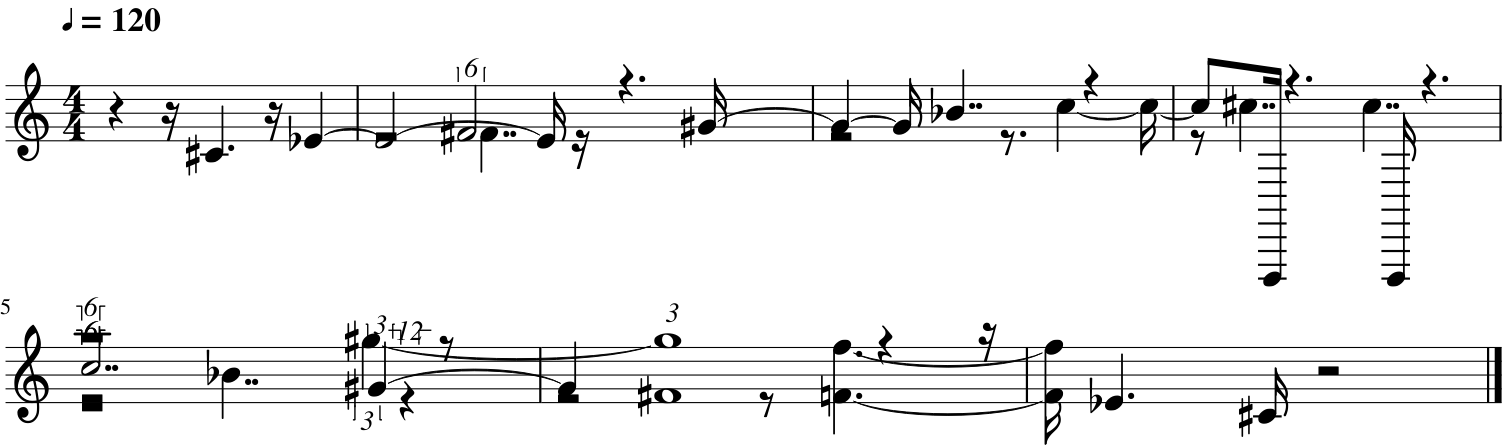

In [ ]:
import music21
parsed = music21.converter.parse('/content/gdrive/MyDrive/AMT/ArtificialDataset/Midi2MidiComp/GeneratedFile.mid')
parsed.show()

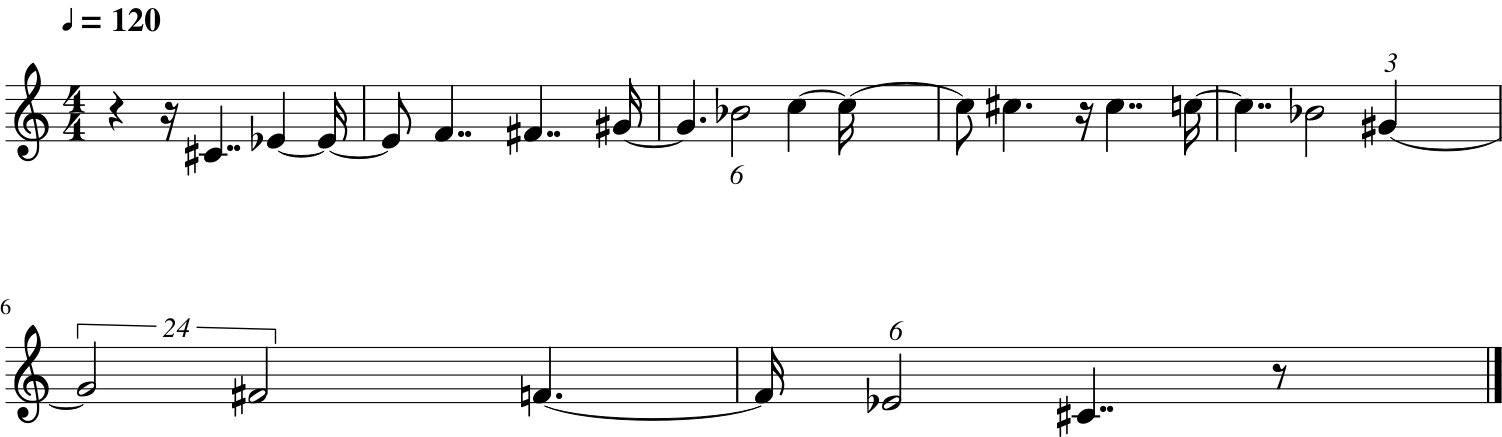

In [ ]:
import music21
parsed = music21.converter.parse('/content/gdrive/MyDrive/AMT/ArtificialDataset/Midi2MidiComp/MidiGTruth.mid')
parsed.show()